In [1]:
import pandas as pd
import gpxo
import gpxpy
import gpxpy.gpx
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.stats import mannwhitneyu
from pytz import timezone
from datetime import datetime

In [2]:
def int_part(x):
    '''
    Returns integer part and rounds the decimal part.
    '''

    part_int = int(x)
    part_dec = x % 1
    if part_dec < 0.5:
        return part_int
    else:
        return float(f"{part_int}.5")
    
def get_pace(velocidade):
    '''
    Calculate the pace.
    '''

    if velocidade > 0:
        pace_min = 60 / velocidade
        minutos = int(pace_min)
        segundos = int((pace_min - minutos) * 60)
        x = f"{minutos}.{segundos:02d}"
        return float(x)
    else:
        return 0
    
def round_minutes(time):
    '''
    Returns the hour and minute so that the minute unit is rounded to the nearest 0 or 5 to the ten. 
    Example: 1:37 will return 1:35; 1:38 will return 1:40.
    '''

    hour = time.hour
    minute = time.minute
    
    if minute % 10 <= 5:
        rounded_minute = (minute // 10) * 10 
    else:
        rounded_minute = ((minute // 10) + 1) * 10 

        if rounded_minute == 60:
            rounded_minute = 0
            hour = (hour + 1) % 24

    return f"{hour:02}:{rounded_minute:02}"

def get_pivot_pace(data: pd.DataFrame, pivot_to: str, plot: True):
    '''
    Pivots the data by the variable of interest, taking pace as the value.
    Args:
        data (pd.DataFrame): The dataframe with the variables to be pivoted.
        pivot_to (str): The variable of interest that will pivot the data.
        plot (bool, optional): The plot with the comparison between pace and the variable of interest.
    Returns:
        A dataframe with the pivoted data.
    '''

    df_pivot = data.pivot_table(
    index=pivot_to, 
    columns="id_user",      
    values="pace",          
    aggfunc="mean"
    ,observed=False
    ).reset_index()

    df_pivot = df_pivot.drop(["corredor_7","corredor_8"], axis = 1)

    if plot:

        plt.subplots(figsize=(8, 5))

        columns = list(df_pivot.columns)
        columns.remove(pivot_to)

        for column in columns:
            plt.plot(df_pivot[pivot_to], df_pivot[column], marker='o', label=column)

        plt.ylabel("pace")
        plt.xlabel(pivot_to)
        plt.legend()
        plt.show()
    
    return df_pivot

In [3]:
# Reading the runners data

folder_path = "data"
id = 1

df = pd.DataFrame()

for file_name in os.listdir(folder_path):
    if file_name.endswith('.gpx'):
        data_path = os.path.join(folder_path, file_name)
        code_data = gpxo.Track(data_path)
        data = code_data.data
        data["id_user_name"] = file_name
        
        df = pd.concat([df,data])

        id += 1

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/gpxo/track.py:127: RuntimeWarning: divide by zero encountered in divide
  vs = 3600 * dd / dt
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/gpxo/track.py:127: RuntimeWarning: invalid value encountered in divide
  vs = 3600 * dd / dt


In [4]:
# Reading runners responses

df_quest = pd.read_csv("data/respostas_corredores_sg.csv")

In [5]:
# Step clean

df.columns = [col.split()[0] for col in df.columns]

df.dropna(subset=['velocity'], inplace=True)
df = df.loc[df.distance > 0]
df = df.loc[df.velocity != np.inf]

In [9]:
# Calculated variables

df["distance_int"] = df.distance.apply(int_part)
df["id_user"] = "corredor_" + df.id_user_name.str.extract(r"(\d+)")
df["pace"] = df.velocity.apply(get_pace)
df["simple_time"] = pd.to_datetime(df.index, format='%H:%M').time
df["round_simple_time"] = df.simple_time.apply(round_minutes)
df["round_elevation"] = df.elevation.apply(int)

bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100, 130, 160, 200]
labels = ['0-20', '21-30', '31-40', '41-50','51-60', '61-70', '71-80', 
          '81-90','91-100', '101-130','131-160', '161-200']
df['range_elevation'] = pd.cut(df['elevation'], bins=bins, labels=labels, right=False)

df["walk"] = 0
df.loc[df.velocity <= 5, "walk"] = 1

df.head()

,latitude,longitude,distance,compass,duration,velocity,elevation,id_user_name,distance_int,id_user,pace,simple_time,round_simple_time,round_elevation,range_elevation,walk
time,,,,,,,,,,,,,,,,
2024-12-15 09:31:51,-22.903941,-43.117206,0.000611,52.973852,15.0,2.3202,9.1,4_sylvia.gpx,0.0,corredor_4,25.51,09:31:51,09:30,9,0-20,1
2024-12-15 09:31:52,-22.903937,-43.117201,0.001289,52.973853,16.0,2.3202,9.1,4_sylvia.gpx,0.0,corredor_4,25.51,09:31:52,09:30,9,0-20,1
2024-12-15 09:31:53,-22.903934,-43.117196,0.001900,97.156944,17.0,2.4588,9.1,4_sylvia.gpx,0.0,corredor_4,24.24,09:31:53,09:30,9,0-20,1
2024-12-15 09:31:54,-22.903939,-43.117191,0.002655,158.681194,18.0,1.5588,9.1,4_sylvia.gpx,0.0,corredor_4,38.29,09:31:54,09:30,9,0-20,1
2024-12-15 09:31:55,-22.903940,-43.117191,0.002766,108.745615,19.0,3.2220,9.1,4_sylvia.gpx,0.0,corredor_4,18.37,09:31:55,09:30,9,0-20,1


Gráfico 1: média de pace em relação ao tempo de prova  
Gráfico 2: média de pace em relação a distância  
Gráfico 3: média de pace em relação a elevação da prova

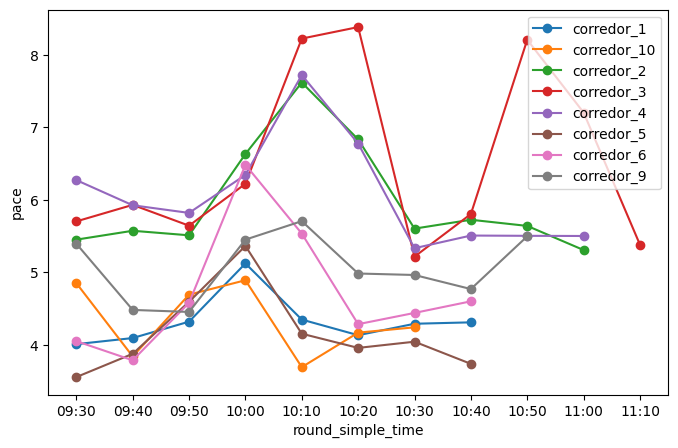

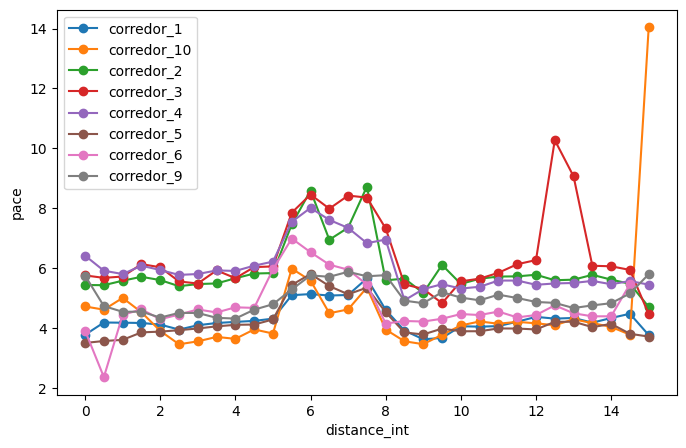

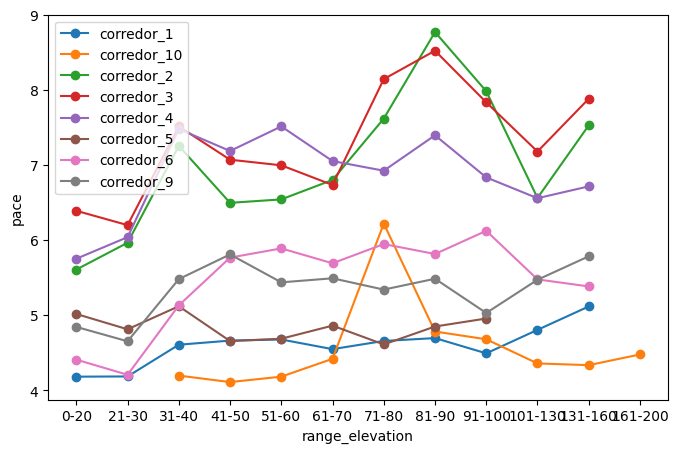

In [12]:
simple_time = get_pivot_pace(df, "round_simple_time", True)
dist = get_pivot_pace(df, "distance_int", True)
elev = get_pivot_pace(df, "range_elevation", True)

In [13]:
result = df.groupby('id_user', as_index=False)['velocity'].mean()
result["final_pace"] = result.velocity.apply(get_pace)

result.sort_values(by="final_pace", ascending=True)

,id_user,velocity,final_pace
1,corredor_10,14.534148,4.07
5,corredor_5,13.869527,4.19
0,corredor_1,13.429047,4.28
6,corredor_6,12.129665,4.56
9,corredor_9,11.844324,5.03
8,corredor_8,10.480546,5.43
4,corredor_4,10.379796,5.46
2,corredor_2,10.367819,5.47
7,corredor_7,10.216133,5.52
3,corredor_3,9.390070,6.23


In [14]:
# Walking

df_w = df.groupby('id_user', as_index=False)['walk'].sum()

df_w

,id_user,walk
0,corredor_1,0
1,corredor_10,21
2,corredor_2,96
3,corredor_3,260
4,corredor_4,105
5,corredor_5,0
6,corredor_6,24
7,corredor_7,0
8,corredor_8,157
9,corredor_9,12


In [15]:
df_quest.head(10)

,id_user,nome,treinou pra prova,fez o percurso antes,tem habito de correr,outros exercicios,quanto tempo corre
0,corredor_1,lucas,1,1,1,1,2 anos
1,corredor_2,luiz,1,0,1,1,3 meses
2,corredor_3,rodrigo,1,0,1,1,5 meses
3,corredor_4,sylvia,1,0,1,1,5 meses
4,corredor_5,jonathan,1,1,1,1,6 anos
5,corredor_6,anonimo,1,1,1,1,7 anos
6,corredor_7,nathalia,0,0,1,1,5 anos
7,corredor_8,pope,1,0,1,1,4 meses
8,corredor_9,matheus,1,0,1,1,1 ano
9,corredor_10,anonimo2,1,1,1,1,7 anos


Testing hypothesis of variation before and after the climb

In [16]:
who = df_quest.loc[df_quest["fez o percurso antes"] == 1]
who = list(who.id_user)

before_dict = {}
in_dict = {}

for c in who:
    avg_pace = float(df.loc[((df.distance_int <= 5) & (df.id_user == c))].pace.mean())
    before_dict[c] = avg_pace

for c in who:
    avg_pace = float(df.loc[((df.distance_int > 5) & (df.distance_int <= 8) & (df.id_user == c))].pace.mean())
    in_dict[c] = avg_pace

who_did = [in_dict[key] - before_dict[key] for key in in_dict if key in before_dict]
who_did

[1.000318539456309, 1.4043647954838554, 1.5291500792236095, 0.9021878297050296]

In [17]:
who = df_quest.loc[df_quest["fez o percurso antes"] != 1]
who = list(who.id_user)

before_dict = {}
in_dict = {}

for c in who:
    avg_pace = float(df.loc[((df.distance_int <= 5) & (df.id_user == c))].pace.mean())
    before_dict[c] = avg_pace

for c in who:
    avg_pace = float(df.loc[((df.distance_int > 5) & (df.distance_int <= 8) & (df.id_user == c))].pace.mean())
    in_dict[c] = avg_pace

who_didnt = [in_dict[key] - before_dict[key] for key in in_dict if key in before_dict]

# Tirando os nulos
who_didnt = [x for x in who_didnt if pd.notnull(x)]
who_didnt

[1.9930814813845341,
 2.2649556679752374,
 1.4211738463572443,
 2.925953349103623,
 1.0382795837850693]

In [18]:
stat, p_value = mannwhitneyu(who_did, who_didnt, alternative='two-sided')

print(f"p-valor: {p_value}")

p-valor: 0.1111111111111111


Testing hypothesis of climbing speed

In [19]:
who = df_quest.loc[df_quest["fez o percurso antes"] == 1]
who = list(who.id_user)

before_dict = {}
in_dict = {}

for c in who:
    avg_pace = float(df.loc[((df.distance_int > 5) & (df.distance_int <= 8) & (df.id_user == c))].pace.mean())
    in_dict[c] = avg_pace

who_did = list(in_dict.values())
who_did

[5.123011664899257, 5.270906148867314, 5.9247138047138055, 5.017955271565495]

In [20]:
who = df_quest.loc[df_quest["fez o percurso antes"] != 1]
who = list(who.id_user)

before_dict = {}
in_dict = {}

for c in who:
    avg_pace = float(df.loc[((df.distance_int > 5) & (df.distance_int <= 8) & (df.id_user == c))].pace.mean())
    in_dict[c] = avg_pace

who_didnt = list(in_dict.values())
who_didnt = [x for x in who_didnt if pd.notnull(x)]
who_didnt

[7.575162055335968,
 8.087077872012335,
 7.403622611464969,
 8.679453894359893,
 5.6867638483965015]

In [21]:
# Teste Mann-Whitney U
stat, p_value = mannwhitneyu(who_did, who_didnt, alternative='two-sided')

print(f"p-valor: {p_value}")

p-valor: 0.031746031746031744


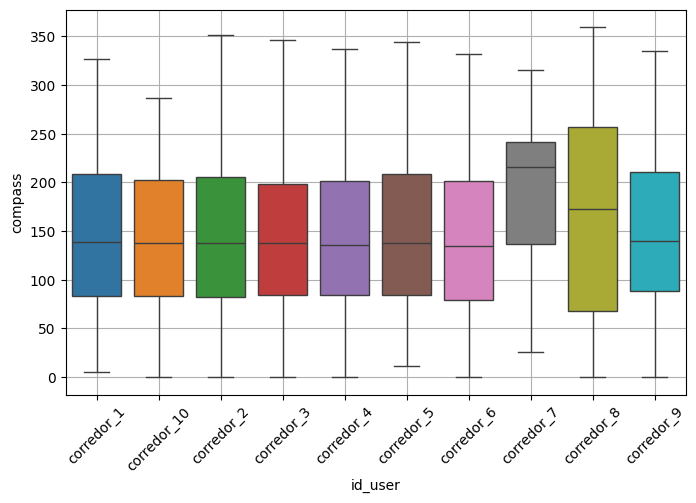

In [22]:
# Compass

pivot_clima = df[['compass','id_user']]
pivot_clima = pivot_clima.pivot(columns='id_user', values='compass')

fig = plt.figure(figsize=(8, 5))
ax = sns.boxplot(data=pivot_clima, orient="v")
plt.ylabel("compass")
plt.xticks(rotation=45)
ax.grid()